# Serial correlation

In [1]:
library(here)
library(haven)
library(sdazar)
library(ggplot2)
library(brms)
options(mc.cores = parallel::detectCores())
library(imputeTS)
options(repr.plot.width = 5, repr.plot.height = 3)
library(texreg)
# library(stringr)
# library(ggridges)
# library(patchwork)

here() starts at /Users/sdaza/GoogleDrive/01Projects/lambda
Loading required package: data.table
Warning message:
“package ‘data.table’ was built under R version 3.4.2”Loading required package: knitr
Warning message:
“package ‘knitr’ was built under R version 3.4.3”Loading required package: miceadds
Loading required package: mice
Warning message:
“package ‘mice’ was built under R version 3.4.2”Loading required package: lattice
* miceadds 2.11-1 (2018-03-29 19:18:54)
Warning message:
“package ‘brms’ was built under R version 3.4.4”Loading required package: Rcpp
Warning message:
“package ‘Rcpp’ was built under R version 3.4.4”Loading 'brms' package (version 2.2.0). Useful instructions
can be found by typing help('brms'). A more detailed introduction
to the package is available through vignette('brms_overview').
Run theme_set(theme_default()) to use the default bayesplot theme.

Attaching package: ‘brms’

The following object is masked from ‘package:sdazar’:

    mi

Version:  1.36.23
Dat

In [2]:
df = data.table(read_stata('../data/Ex_LA1850-2013_SES_ABBREVIATED_april-3-2018.dta'))

country_labels = c("Argentina", "Bolivia", "Brazil", "Chile", "Colombia",
                   "Costa_Rica", "Cuba", "Dominican_Republic", "Ecuador",
                   "El_Salvador", "Guatemala", "Honduras", "Mexico", "Nicaragua",
                   "Panama", "Paraguay", "Peru", "Uruguay", "Venezuela")

df[, ctry := factor(ctry, labels=country_labels)]

head(df)

ctry,year,sex,age,Ex,piv,name,tseries1,tseries2,gdp_pc,⋯,extFund,healthGdp,lsi,polio,bcg,dpt1,dpt3,mcv1,us_aid,lunion
Argentina,1869,1,0,30.69283,1,1,1,1,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,1901
Argentina,1869,1,5,44.80823,1,1,1,1,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,1901
Argentina,1869,1,60,10.85571,1,1,1,1,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,1901
Argentina,1869,2,0,34.44617,1,1,1,1,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,1901
Argentina,1869,2,5,47.21839,1,1,1,1,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,1901
Argentina,1869,2,60,11.67697,1,1,1,1,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,1901


In [4]:
# select covarites
covariates = names(df)[10:28]

c = df[tseries2==1 & age==0 & year>=1900, lapply(.SD,Max),
       .SDcols=covariates, by=.(ctry, year)]

le = df[tseries2==1 & age==0 & year>=1900, .(Ex=Mean(Ex)), by=.(ctry, year)]

# check
(nrow(c) + nrow(le))/2

dt = merge(c, le, by=c('ctry', 'year'))

# missing data
print(countmis(dt))

[1] 1848

       bf      elec       lsi       lit   extFund      gini     water    sewage 
    0.977     0.951     0.922     0.852     0.844     0.820     0.775     0.773 
healthGdp     polio       bcg      dpt1      dpt3      mcv1     urban       tfr 
    0.709     0.681     0.681     0.681     0.681     0.681     0.451     0.445 
   us_aid    gdp_pc 
    0.360     0.103 


In [6]:
# define dataset

test = dt[year>=1900, .(ctry, year, gdp_pc, urban, lit, Ex, water, sewage, elec, us_aid, tfr)]

# periods
test[year<1950, gyear:='1950']
test[year>=1950 & year<1970, gyear:='1950-1969']
test[year>=1970 & year<1990, gyear:='1970-1989']
test[year>=1990, gyear :='1990']

# transform variable: weibull
test[, y := Ex/max(Ex+1.05), by = ctry] # adjustment is by country!
test[, wy := log(-log(1-y))]
max_le = test[, .(max_le = max(Ex+1.05)), by = ctry] # to recover values later
test[, ctry_year := paste0(ctry,'.', gyear)]

# define order
setorder(test, year)

# interpolation
test[, igdp_pc := na.interpolation(gdp_pc, option='stine'), by=ctry]
test[, iurban := na.interpolation(urban, option='stine'), by=ctry]
test[, ilit := na.interpolation(lit, option='stine'), by=ctry]
test[, itfr := na.interpolation(tfr, option='stine'), by=ctry]

test[, igdp_log := scale(log(igdp_pc), scale=FALSE, center=TRUE)]
test[, iurban_log := scale(log(iurban), scale=FALSE, center=TRUE)]
test[, ilit_log := scale(log(ilit), scale=FALSE, center=TRUE)]

# Filtering example: Chile

In [7]:
# filtering
chile = test[ctry=='Chile']
uruguay = test[ctry=='Uruguay']

In [9]:
vars = c('ctry', 'year', 'iurban', 'igdp_pc', 'ilit', 'itfr', 'Ex', 
        'water', 'sewage', 'elec')

In [10]:
chiles = chile[, vars, with=FALSE]

In [12]:
vars = c('water', 'sewage', 'elec')
i = which(names(chiles) %in% vars)
bounds = cbind(i, rep(0, length(i)), rep(100, length(i)))

In [13]:
bounds

i,,
8,0,100
9,0,100
10,0,100


In [17]:
names(chiles)

In [34]:
fwrite(chiles, 'chile.csv')

In [30]:
chiles[, ctry := as.character(ctry)]

In [31]:
### imputation usign amelia for chile
library(Amelia)
library(parallel)


imp1 = amelia(as.data.frame(chiles), 
              bounds = bounds, 
              m=5, # only five!
              ts = 'year', cs = 'ctry', 
              splinetime = 4, intercs = TRUE,  
              p2s = 0, 
              logs=c('igdp_pc', 'iurban', 'ilit', 'itfr','Ex', 'water', 'sewage', 'elec'), 
              lags = c('igdp_pc', 'Ex', 'iurban', 'itfr', 'ilit'), 
              leads = c('Ex', 'igdp_pc', 'iurban', 'itfr', 'ilit'),
              empri = .01*nrow(chiles), 
              parallel='multicore', ncpus=3)

In [32]:
library(miceadds)

In [33]:
imputations = datalist2mids(imp1$imputations)

Warning message in data.matrix(x):
“NAs introduced by coercion”Warning message in data.matrix(x):
“NAs introduced by coercion”

In [64]:
setorder(chile, year)
setorder(uruguay, year)

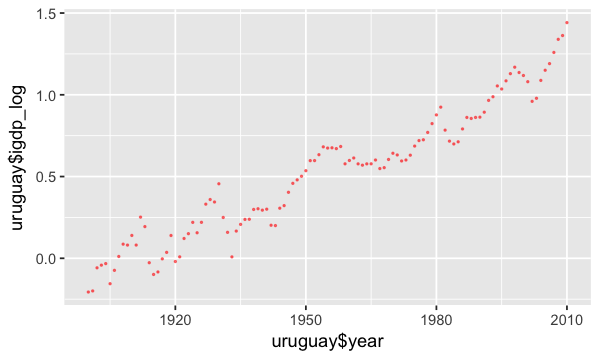

In [65]:
ggplot(NULL, aes(x=uruguay$year, y=uruguay$igdp_log)) + geom_point(color='red', alpha=0.5, size=0.3)

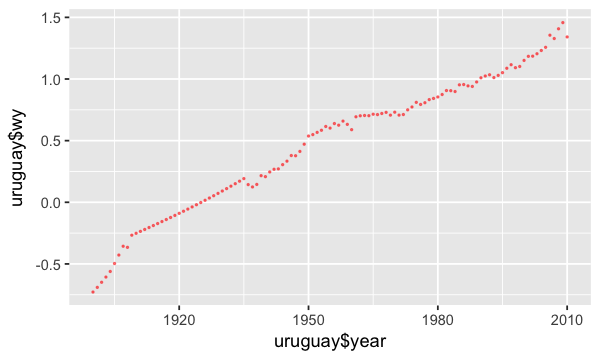

In [66]:
ggplot(NULL, aes(x=uruguay$year, y=uruguay$wy)) + geom_point(color='red', alpha=0.5, size=0.3)

## Linear regression 

In [38]:
m1 = lm(wy ~  lag_igdp_log, data=uruguay)

print(screenreg(m1))

ERROR: Error in eval(predvars, data, env): object 'lag_igdp_log' not found


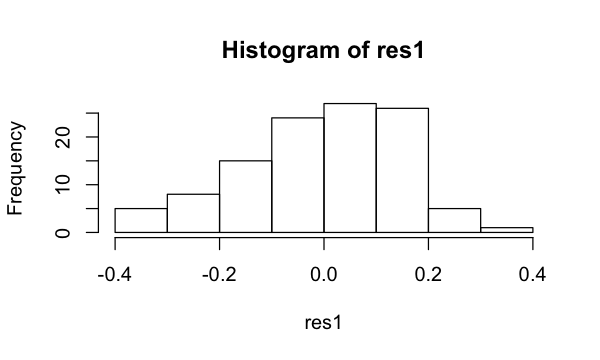

In [68]:
res1 = resid(m1)
hist(res1)

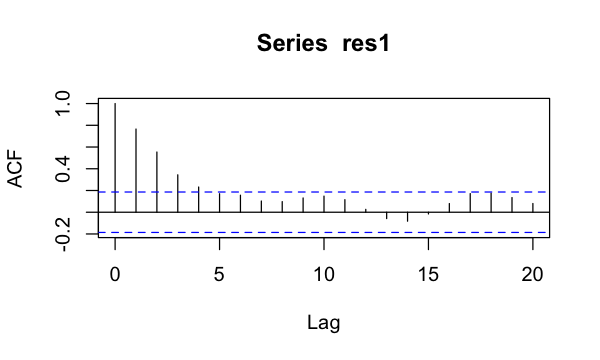

In [69]:
# autocorrelation
ac = acf(res1,pl=TRUE) # huge correlation first lag

This is clearly misspecification of the model. 

In [70]:
print(ac)


Autocorrelations of series ‘res1’, by lag

     0      1      2      3      4      5      6      7      8      9     10 
 1.000  0.765  0.554  0.344  0.232  0.170  0.157  0.103  0.098  0.131  0.148 
    11     12     13     14     15     16     17     18     19     20 
 0.116  0.026 -0.058 -0.082 -0.016  0.080  0.171  0.176  0.135  0.080 


In [90]:
r1 =  ac$acf[2] # assuming AR1

In [50]:
# compute lags
uruguay[, lag_1_igdp_log := shift(igdp_log, 1)]
uruguay[, lag_2_igdp_log := shift(igdp_log, 2)]
uruguay[, lag_3_igdp_log := shift(igdp_log, 3)]
uruguay[, lag_4_igdp_log := shift(igdp_log, 4)]
uruguay[, lag_year := shift(year)]
uruguay[, lag_wy := shift(wy)]

head(uruguay[, .(year, igdp_log, lag_igdp_log, wy, lag_wy, year, lag_year)])

year,igdp_log,lag_igdp_log,wy,lag_wy,year,lag_year
1900,-0.20628044,NA,-0.7278755,NA,1900,NA
1901,-0.19965229,-0.20628044,-0.6901556,-0.7278755,1901,1900
1902,-0.05827443,-0.19965229,-0.6487393,-0.6901556,1902,1901
1903,-0.04188937,-0.05827443,-0.6064339,-0.6487393,1903,1902
1904,-0.03247715,-0.04188937,-0.5610712,-0.6064339,1904,1903
1905,-0.15541815,-0.03247715,-0.4967171,-0.5610712,1905,1904


In [101]:
r1

[1] 0.7653737

In [98]:
uruguay[, f_wy := wy - r1*lag_wy]
uruguay[, f_igdp_log := igdp_log - r1*lag_igdp_log]

Warning message:
“Removed 1 rows containing missing values (geom_point).”

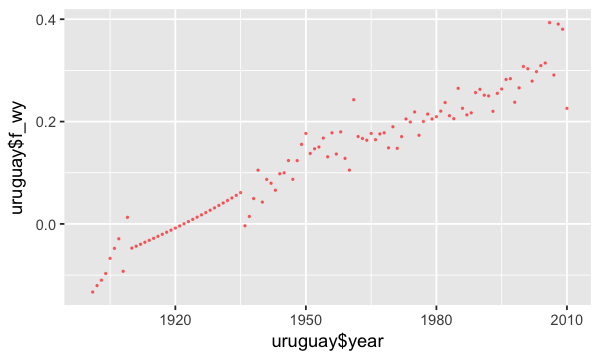

In [105]:
ggplot(NULL, aes(x=uruguay$year, y=uruguay$f_wy)) +geom_point(color='red', alpha=0.5, size=0.3)

Warning message:
“Removed 1 rows containing missing values (geom_point).”

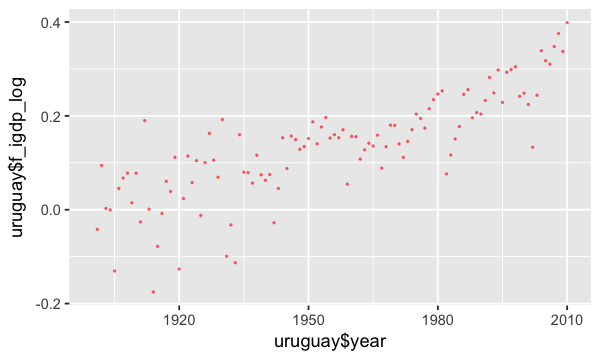

In [104]:
ggplot(NULL, aes(x=uruguay$year, y=uruguay$f_igdp_log)) +geom_point(color='red', alpha=0.5, size=0.3)

In [64]:
m1f =  lm(wy ~ lag_2_igdp_log + igdp_log, data = uruguay)

print(screenreg(m1f))


                Model 1   
--------------------------
(Intercept)      -0.20 ***
                 (0.02)   
lag_2_igdp_log    0.76 ***
                 (0.12)   
igdp_log          0.57 ***
                 (0.12)   
--------------------------
R^2               0.94    
Adj. R^2          0.94    
Num. obs.       109       
RMSE              0.13    
*** p < 0.001, ** p < 0.01, * p < 0.05


In [67]:
res1f = resid(m1f)

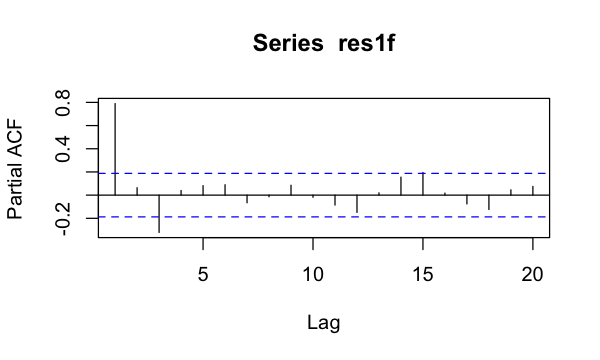

In [68]:
pacf(res1f)

In [127]:
m1f = brm(formula = f_wy ~ 1 + f_igdp_log, 
           data = uruguay,
           iter = 2000, 
           chains = 2)

Warning message:
“Rows containing NAs were excluded from the model.”Compiling the C++ model
Start sampling


In [129]:
summary(m1f)

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: f_wy ~ 1 + f_igdp_log 
   Data: uruguay (Number of observations: 110) 
Samples: 2 chains, each with iter = 2000; warmup = 1000; thin = 1; 
         total post-warmup samples = 2000
    ICs: LOO = NA; WAIC = NA; R2 = NA
 
Population-Level Effects: 
           Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
Intercept      0.01      0.01    -0.01     0.03       1747 1.00
f_igdp_log     0.87      0.07     0.74     1.00       1661 1.00

Family Specific Parameters: 
      Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sigma     0.08      0.01     0.07     0.09       1601 1.00

Samples were drawn using sampling(NUTS). For each parameter, Eff.Sample 
is a crude measure of effective sample size, and Rhat is the potential 
scale reduction factor on split chains (at convergence, Rhat = 1).

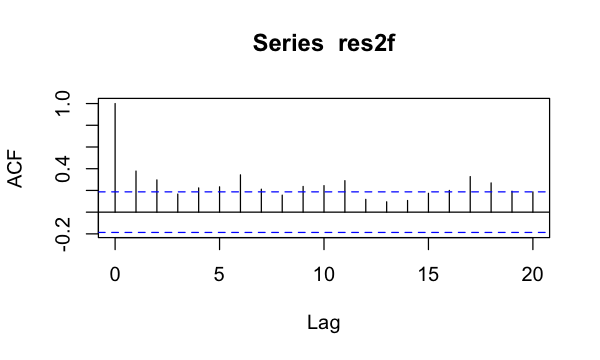

In [131]:
res2f = resid(m1f, type = 'pearson')[, "Estimate"]
acf(res2f)

Still signs of serial correlation. 

# Bayesian approach 

In [33]:
m2 = brm(formula = wy ~ 1 + igdp_log,
          data = chile,
          iter = 2000,
          chains = 2)

summary(m2)

Compiling the C++ model
Start sampling


 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: wy ~ 1 + igdp_log 
   Data: chile (Number of observations: 111) 
Samples: 2 chains, each with iter = 2000; warmup = 1000; thin = 1; 
         total post-warmup samples = 2000
    ICs: LOO = NA; WAIC = NA; R2 = NA
 
Population-Level Effects: 
          Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
Intercept    -0.44      0.03    -0.49    -0.39       1528 1.00
igdp_log      1.30      0.04     1.23     1.37       1513 1.00

Family Specific Parameters: 
      Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sigma     0.20      0.01     0.18     0.23       2000 1.00

Samples were drawn using sampling(NUTS). For each parameter, Eff.Sample 
is a crude measure of effective sample size, and Rhat is the potential 
scale reduction factor on split chains (at convergence, Rhat = 1).

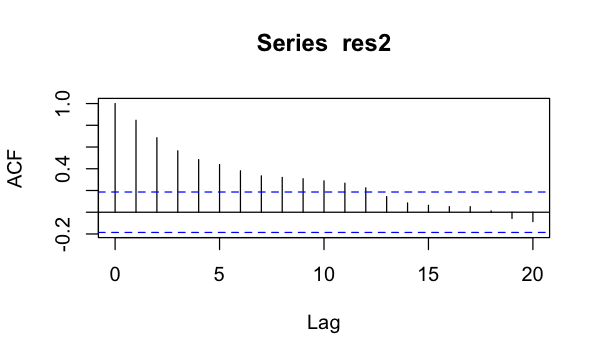

In [49]:
res2 = resid(m2, type = 'pearson')[, "Estimate"]
acf(res2) # similar pattern to frequentist approach but not exactly the same

In [111]:
m2f = brm(formula = wy ~ 1 + igdp_log,
          autocor = cor_ar(~ 1, p=1), # I am not sure how to reproduce frequentist model m1f
          data = uruguay,
          iter = 2000,
          chains = 2)

summary(m2f)

Compiling the C++ model
Start sampling


 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: wy ~ 1 + igdp_log 
   Data: uruguay (Number of observations: 111) 
Samples: 2 chains, each with iter = 2000; warmup = 1000; thin = 1; 
         total post-warmup samples = 2000
    ICs: LOO = NA; WAIC = NA; R2 = NA
 
Correlation Structures:
      Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
ar[1]     1.00      0.00     1.00     1.00       2000 1.00

Population-Level Effects: 
          Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
Intercept    -0.71      0.04    -0.78    -0.64       1196 1.00
igdp_log      0.07      0.05    -0.03     0.17        940 1.00

Family Specific Parameters: 
      Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sigma     0.04      0.00     0.03     0.04       1443 1.00

Samples were drawn using sampling(NUTS). For each parameter, Eff.Sample 
is a crude measure of effective sample size, and Rhat is the potential 
scale reduction factor on split chains (at convergence, Rhat

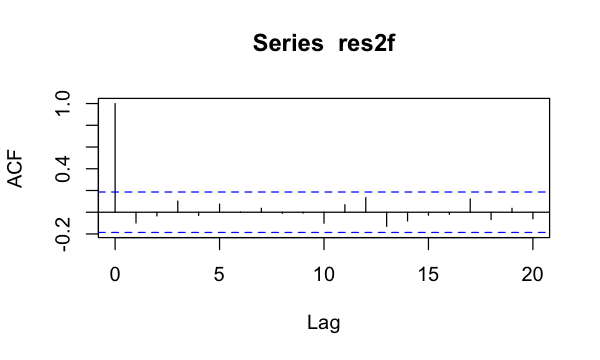

In [110]:
res2f = resid(m2f, type = 'pearson')[, "Estimate"]
acf(res2f)

In [ ]:
sessionInfo()